**Name:** WANG Shixiang

 Tweet Sentiment Analysis

## Goal
The task is predict the sentiment of Tweets about four technology companies, Apple, Microsoft, Google, and Twitter. Here are some examples of tweets with different sentiments:
  - **positive**: _"http://t.co/QV4m1Un9 Forget the phone.. Nice UI. Liking the Scroll Feature #android #google #nexus"_
  - **negative**: _"Have never had such poor customer service at @Apple before! What happened? (@ Apple Store w/ 2 others) http://t.co/GKlXMUi6"_
  - **neutral**: _"The lock screen now has facial recognition capability! #Google #Android #ICS"_.

# Load the Data

The training data is in the text file `sanders_tweets_train.txt`.  This CSV file contains the  tweet, labels, and topics. The class labels are: `"positive"`, `"neutral"`, and `"negative"`. The training data also includes the corresponding tweet topics: `"apple"`, `"microsoft"`, `"google"`, and `"twitter"`.

In [ ]:
import re
import string
import collections
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from pprint import pprint
from time import time

sns.set(style="darkgrid")
sns.set(font_scale=0.5)
warnings.simplefilter('ignore')

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from spellchecker import SpellChecker

In [2]:
def read_text_data(fname):
    txtdata = []
    classes = []
    topics  = []
    with open(fname, 'r', encoding='utf8') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='"')
        for row in reader:
            # get the text
            txtdata.append(row[0])
            # get the class (convert to integer)
            if len(row)>1:
                classes.append(row[1])
                topics.append(row[2])
    
    if (len(classes)>0) and (len(txtdata) != len(classes)):        
        raise Exception("mismatched length!")
    
    return (txtdata, classes, topics)

def write_csv_kaggle_sub(fname, Y):
    # fname = file name
    # Y is a list/array with class entries
    
    # header
    tmp = [['Id', 'Prediction']]
    
    # add ID numbers for each Y
    for (i,y) in enumerate(Y):
        tmp2 = [(i+1), y]
        tmp.append(tmp2)
        
    # write CSV file
    with open(fname, 'w') as f:
        writer = csv.writer(f)
        writer.writerows(tmp)

The below code will load the training and test sets.

In [3]:
# load the data
# (if using Kaggle notebooks you need to include the directory path: /kaggle/input/cs5489-2020b-assignment-1/)
(traintxt, trainY, traintopic) = read_text_data("sanders_tweets_train.txt")
(testtxt, _, _)                = read_text_data("sanders_tweets_test.txt")

print(len(traintxt))
print(len(testtxt))

2396
1028


In [4]:
classnames = set(trainY)
print(classnames)

{'neutral', 'positive', 'negative'}


Look at the data:

In [5]:
print(trainY[0])
print(traintopic[0])
print(traintxt[0])

positive
google
http://t.co/QV4m1Un9 Forget the phone.. Nice UI. Liking the Scroll Feature #android #google #nexus


### Exploratory Data Analysis
- Create a TextCount class for counting features from data before cleaning
    - word counts for each tweet
    - number of urls in each tweet
    - number of hashtags in each tweet
    - numer of mentions in each tweet
    - number of Capital Letter used
    - number of exclamation or qustion marks

In [7]:
# Class for counting features
class TextCount(BaseEstimator, TransformerMixin):
    def count_word(self, input_text):
        # count all patterns matching \w+, which are words
        return len(re.findall(r'\w+', input_text))
    
    def count_mention(self, input_text):
        # count all patterns matching @\w+, which are mentions
        return len(re.findall(r'@\w+', input_text))
    
    def count_hashtag(self, input_text):
        # count all patterns matching #\w+, which are hashtags, repeating hashtags count
        return len(re.findall(r'#\w+', input_text))
    
    def count_capital(self, input_text):
        # count all patterns matching \b[A-Z]{2,}\b, which are captial words
        return len(re.findall(r'\b[A-Z]{2,}\b', input_text))
    
    def count_exclquest(self, input_text):
        # count all patterns matching !|\?, which are exclamation or question marks
        return len(re.findall(r'!|\?', input_text))
    
    def count_url(self, input_text):
        # count all patterns matching \w+, which are words
        return len(re.findall(r'http.?://[^\s]+[\s]?', input_text))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        count_words = X.apply(self.count_word) 
        count_mentions = X.apply(self.count_mention)
        count_hashtags = X.apply(self.count_hashtag)
        count_capital_words = X.apply(self.count_capital)
        count_excl_quest_marks = X.apply(self.count_exclquest)
        count_urls = X.apply(self.count_url)
        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                          })
        
        return df

- Count features and read them into dataframe df_eda
    - combine with train target trainY

In [8]:
# read traintxt and trainY into pandas dataframes
df_train = pd.DataFrame(traintxt, columns=['text'])
df_sentiment = pd.DataFrame(trainY, columns=['sentiment'])

# count the features and load into a dataframe
tc = TextCount()
df_eda = tc.fit_transform(df_train.text)
df_eda['sentiment'] = df_sentiment.sentiment
df_eda

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,sentiment
0,16,0,3,1,0,1,positive
1,11,0,1,0,0,0,neutral
2,23,1,0,0,2,0,negative
3,11,0,3,1,1,0,neutral
4,9,1,5,1,0,0,neutral
...,...,...,...,...,...,...,...
2391,23,1,1,0,2,0,neutral
2392,2,0,1,0,0,0,neutral
2393,14,1,2,2,0,0,neutral
2394,24,0,2,1,0,2,neutral


- Plot relationsihps between count_words and sentiment

Descriptive stats for count_words
---------------------------------
            count       mean       std  min   25%   50%   75%   max
sentiment                                                          
negative    403.0  17.744417  6.426135  3.0  13.0  19.0  23.0  32.0
neutral    1630.0  16.098160  5.685555  1.0  12.0  16.5  20.0  31.0
positive    363.0  15.487603  6.009361  2.0  12.0  16.0  20.0  29.0


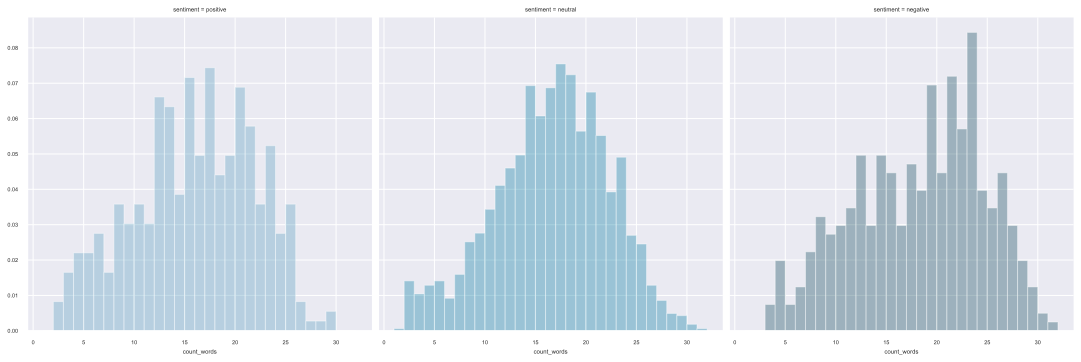

In [9]:
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('sentiment')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='sentiment', height=5, hue='sentiment', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()
    
show_dist(df_eda, 'count_words')

- There are significantly more neutral tweet than the others
- Number of words used for each tweet is rather low, with max = 32, need to be careful during cleaning
- Judging form the plots, negative tweets tend to use more words than the others
    - Maybe negativie opinion needs more justification
- Therefore, this feature will be retained for training

Number of tweets that dont have mentions: 1200
Descriptive stats for count_mentions
------------------------------------
            count      mean       std  min  25%  50%  75%  max
sentiment                                                     
negative    403.0  0.853598  0.792317  0.0  0.0  1.0  1.0  4.0
neutral    1630.0  0.745399  1.064333  0.0  0.0  0.0  1.0  8.0
positive    363.0  0.680441  0.902622  0.0  0.0  0.0  1.0  8.0


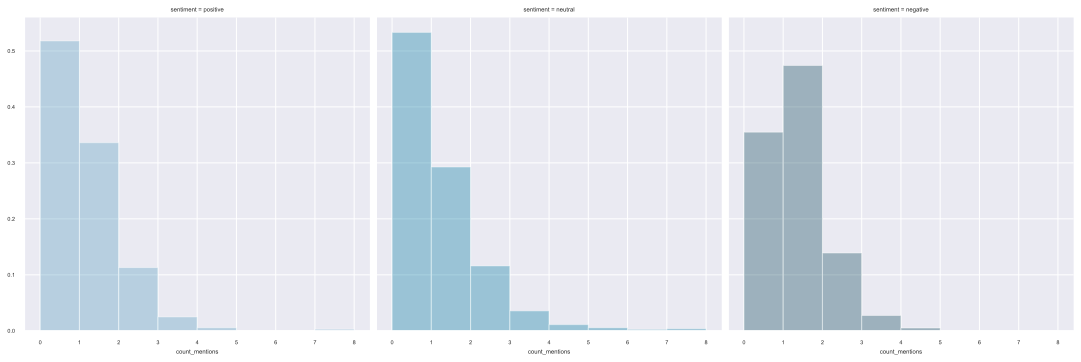

In [10]:
print("Number of tweets that dont have mentions: {}".format((df_eda.count_mentions == 0).sum()))
show_dist(df_eda, "count_mentions")

- Most of the tweets dont have mentions
- Judging from the plot, all sentiment classes share similar distributions
- This feature will be discarded during training

Number of tweets that dont have hashtags: 408
Descriptive stats for count_hashtags
------------------------------------
            count      mean       std  min  25%  50%  75%   max
sentiment                                                      
negative    403.0  1.379653  1.379409  0.0  0.0  1.0  2.0   8.0
neutral    1630.0  2.196319  1.716775  0.0  1.0  2.0  3.0  13.0
positive    363.0  1.779614  1.394909  0.0  1.0  2.0  3.0   7.0


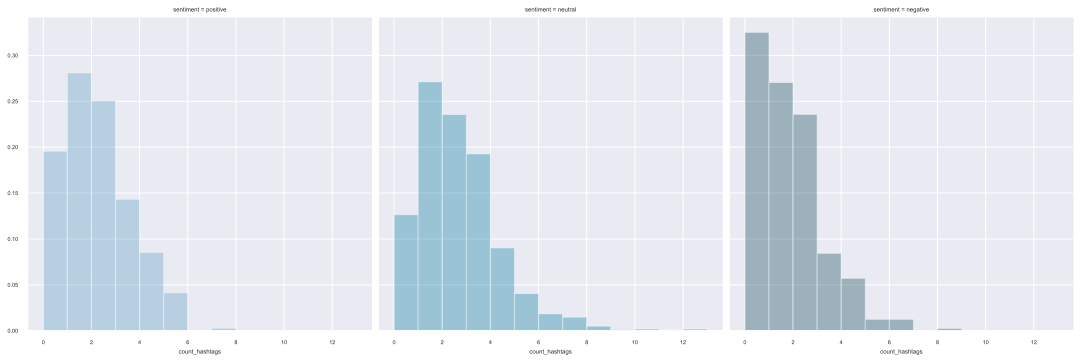

In [11]:
print("Number of tweets that dont have hashtags: {}".format((df_eda.count_hashtags == 0).sum()))
show_dist(df_eda, "count_hashtags")

- Most of the tweets have at least one hashtags
- Judging from the plots, negative tweets tend to use hashtags more often than the others
- This feature will be retained for training

Number of tweets that dont have captial words: 1562
Descriptive stats for count_capital_words
-----------------------------------------
            count      mean       std  min  25%  50%  75%   max
sentiment                                                      
negative    403.0  0.660050  1.865120  0.0  0.0  0.0  1.0  21.0
neutral    1630.0  0.541718  1.174902  0.0  0.0  0.0  1.0  17.0
positive    363.0  0.523416  1.142536  0.0  0.0  0.0  1.0  11.0


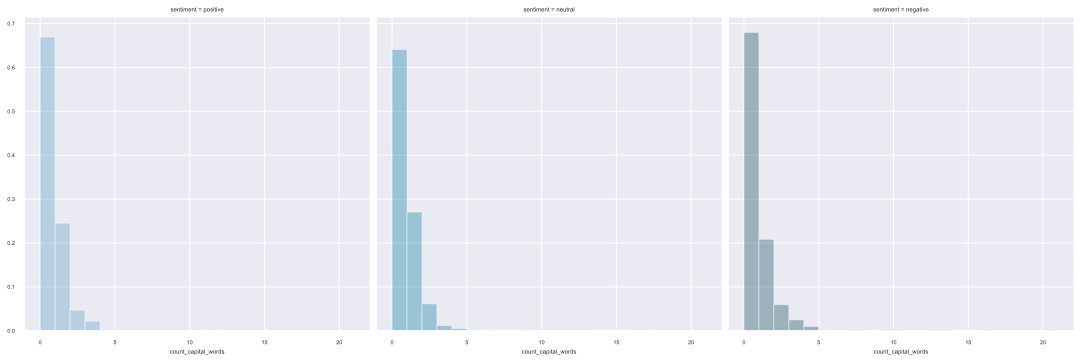

In [12]:
print("Number of tweets that dont have captial words: {}".format((df_eda.count_capital_words == 0).sum()))
show_dist(df_eda, "count_capital_words")

- Feature discraded due to the same reason for mentions

Number of tweets that dont have excal/quest marks: 1679
Descriptive stats for count_excl_quest_marks
--------------------------------------------
            count      mean       std  min  25%  50%  75%   max
sentiment                                                      
negative    403.0  0.684864  1.246864  0.0  0.0  0.0  1.0  11.0
neutral    1630.0  0.392638  0.858537  0.0  0.0  0.0  1.0  10.0
positive    363.0  0.705234  1.442699  0.0  0.0  0.0  1.0  12.0


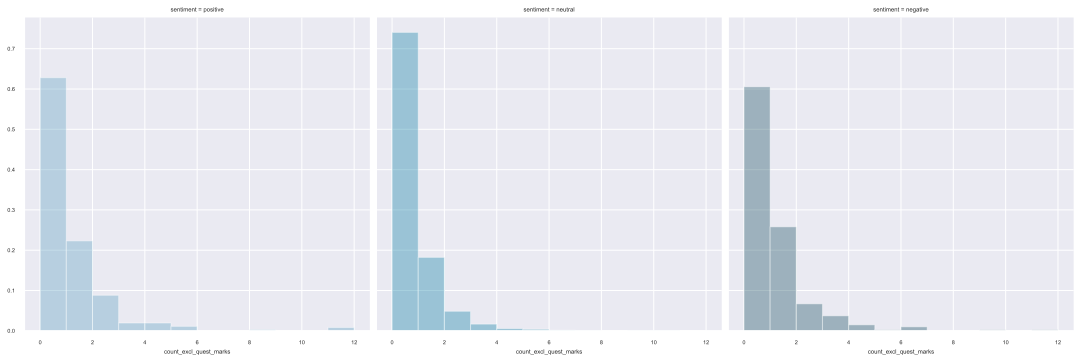

In [13]:
print("Number of tweets that dont have excal/quest marks: {}".format((df_eda.count_excl_quest_marks == 0).sum()))
show_dist(df_eda, "count_excl_quest_marks")

- Feature discraded due to the same reason for mentions

Number of tweets that dont have urls: 1338
Descriptive stats for count_urls
--------------------------------
            count      mean       std  min  25%  50%  75%  max
sentiment                                                     
negative    403.0  0.196030  0.403695  0.0  0.0  0.0  0.0  2.0
neutral    1630.0  0.546012  0.523276  0.0  0.0  1.0  1.0  3.0
positive    363.0  0.305785  0.473198  0.0  0.0  0.0  1.0  2.0


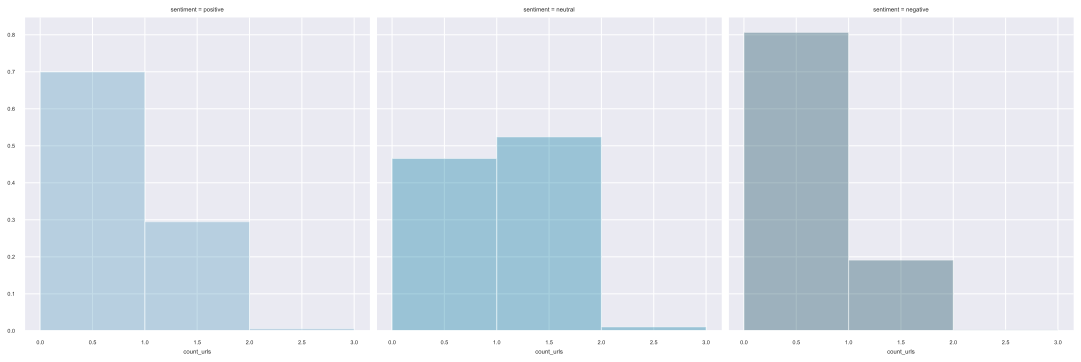

In [14]:
print("Number of tweets that dont have urls: {}".format((df_eda.count_urls == 0).sum()))
show_dist(df_eda, "count_urls")

- About half of the tweets dont have a url
- However, distributions show noticable difference among classes
- Feature keeps for training

### Data Cleaning and Preprocessing
- Create a cleaner class which will apply cleaning actions to input data, including:
    - Turning all data to lowercase letter
    - Remove all punctuations and special letters
    - Remove all digits and words containing digits
    - Normalizing words with lemmatization
    - Check and correct for spelling

In [15]:
# Class for test cleaning
class CleanText(BaseEstimator, TransformerMixin):
    def remove_mentions(self, input_text):
        # remove all '@' mentions
        return re.sub(r'@\w+', '', input_text)
    
    def remove_hashtags(self, input_text):
        # remove all '#' hashtags
        return re.sub(r'#\w+', '', input_text)
    
    def remove_urls(self, input_text):
        # remove all urls
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def remove_punctuation(self, input_text):
        # remove all punctuations
        punct = string.punctuation # Make the translation table
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)    
    
    def remove_digits(self, input_text):
        # remove all numerical values
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        # all text to lowercase
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # some stopwords may indicate sentiment
        whitelist = ["n't", "not", "no"]
        words = input_text.split()
        # a single letter is deemed meaningless as well
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def lemmatize(self, input_text):
        # replace words with its stem
        wnl = WordNetLemmatizer()
        words = input_text.split() 
        # porterstemmer sometimes erases the trailling 'e'
        stemmed_words = [wnl.lemmatize(word) for word in words]
        return " ".join(stemmed_words)
    
    def correct_spelling(self, input_text):
        spell = SpellChecker()
        return ' '.join([spell.correction(word) for word in input_text.split()])
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions) \
                    .apply(self.remove_hashtags) \
                    .apply(self.remove_urls) \
                    .apply(self.remove_punctuation) \
                    .apply(self.remove_digits) \
                    .apply(self.to_lower) \
                    .apply(self.correct_spelling) \
                    .apply(self.lemmatize) \
                    .apply(self.remove_stopwords)
        return clean_X


In [16]:
# clean the training data
ct = CleanText()
traintxt_cleaned = ct.fit_transform(df_train.text)

# Take a look into the cleaned training data
print(traintxt_cleaned.sample(5))

134               iphone show key design component change
1016    suck threw panorama app standard oh pleasant b...
1500    like criticise steve baller face face pain suf...
168     respect really think apple logo revised one no...
1518                noticed ha added like tweet icon page
Name: text, dtype: object


- Text Cleaning side effect:
    - Some entries become empty after cleaning.
    - Can replace empty entries with a placeholder "[empty_entry]"
        - Hold to space for replacing with the average of all vectors in the future!
        - If word vector technique is to be used

In [17]:
# get the indices of empty entries
#empty_train = [i for i, x in enumerate(traintxt_cleaned) if not x]
#empty_test = [i for i, x in enumerate(testtxt_cleaned) if not x]
# insert placeholder for empty entry
#traintxt_cleaned.loc[empty_train] = '[empty_entry]'
#testtxt_cleaned.loc[empty_test] = '[empty_entry]'

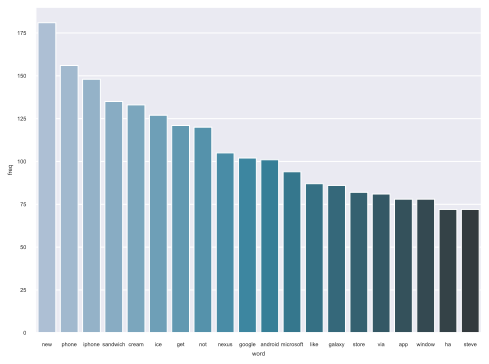

In [18]:
# getting the bag of words
cnvect = CountVectorizer()
trainX = cnvect.fit_transform(traintxt_cleaned)

word_freq = dict(zip(cnvect.get_feature_names(), np.asarray(trainX.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])

# plotting
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();

- from the plot, we can say that
    - data cleaning is satisfiable as
        - there is no broken or misspelled words
        - all words are somehow meaningful
    - However, many words in this bag cannot indicate clear sentiments
        - need to fix it by TFIDF
    - The most frequent words like new and phone probably indicates that some of the companies are launching new products during the time when these data are collected.

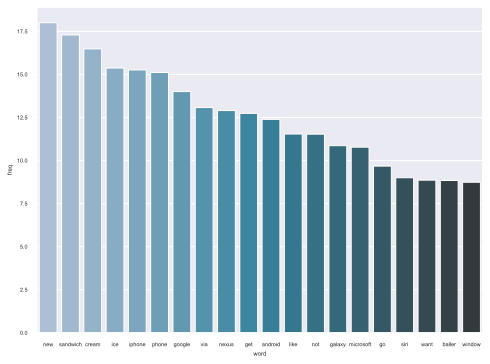

In [19]:
# Apply TFIDF
tf_vect = TfidfVectorizer(use_idf=True, norm='l1')
trainXtf = tf_vect.fit_transform(traintxt_cleaned)

# Lets take a look what the most frequent words look like
word_freq = dict(zip(cnvect.get_feature_names(), np.asarray(trainXtf.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])

# plotting
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();

- After applying TFIDF, some words like "great, like, want" which indicates clear sentiments got ranked up.
- But still cant see a word with negative feeling.
    - My guess is that people tend to express their negativity in an implicity manner, in constrast to the explicit manner when they express positivity.
    
- Now that we finished data cleaning and the result makes sense, we can get the data ready for training and producing the final results

- Get the training data ready

In [20]:
# Append the cleaned text to the eda feature dataframe
df_model = df_eda
df_model['clean_text'] = traintxt_cleaned

# Split the dataframe with training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_model.drop(columns=['sentiment',
                                                                       'count_mentions',
                                                                       'count_capital_words',
                                                                       'count_excl_quest_marks',
                                                                      ]), 
                                                    df_model.sentiment, 
                                                    test_size=0.1, 
                                                    random_state=4489
                                                   )

X_train

,count_words,count_hashtags,count_urls,clean_text
1610,8,1,0,haha thought everybody knew suck
2267,19,3,1,latest offering leaf praying blue screen death
2116,19,3,0,event folk help create window azure pas ex blaze
377,18,1,0,took month decide tonight chosen amazon image ...
616,10,3,0,got best
...,...,...,...,...
1613,4,1,0,get
725,15,0,1,fan eric holder spotted genius store
2233,15,2,1,resolve incorrect file association
1821,20,0,0,partnership would great sum io device would us...


- Get the quest data ready

In [21]:
# Count features for the original testtxt
df_task = pd.DataFrame(testtxt, columns=['text'])
pred_task = tc.fit_transform(df_task.text)
# Drop the unneeded columns
pred_task = pred_task.drop(columns=['count_mentions','count_capital_words','count_excl_quest_marks'])
# Append cleaned text
pred_task['clean_text'] = ct.fit_transform(df_task.text)
pred_task

,count_words,count_hashtags,count_urls,clean_text
0,24,1,0,get flash please please please change mind tha...
1,9,1,1,mixtape
2,15,2,0,apple orange maybe way engaging content stalke...
3,13,0,0,thanks update ha succesfully bricked ipod
4,5,1,0,whats goin fam
...,...,...,...,...
1023,22,2,0,doe anyone good online training tip using info...
1024,16,5,1,announces based beam sharing phone
1025,20,2,1,sassing google lana hoje galaxy nexus android
1026,12,2,1,eye new approach social


#### Model Training, Testing, and Prediction
- Build a cross validation pipeline which
    - Transform all different kinds of features (if any) into one
    - Use GridSearchCV class to cross-validate the best parameter for vectorizer & classifier
    - Print the score and parameters selected by the pipeline

In [22]:
# Transformer that performs the task of extracting feature columns from the dataframe
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols

    def transform(self, X, **transform_params):
        return X[self.cols]

    def fit(self, X, y=None, **fit_params):
        return self

# Based on http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html
def grid_vect(clf, parameters_clf, X_train, X_test, vect=None, parameters_text=None):
    # features reserved for model training after EDA
    textcountscols = ['count_hashtags','count_urls','count_words']
    
    # Union the numerical counting features with clean and vectorized sample text
    # This estimator applies a list of transformer objects in parallel to the
    # input data, then concatenates the results. This is useful to combine
    # several feature extraction mechanisms into a single transformer.
    features = FeatureUnion(
        [('textcounts', ColumnExtractor(cols=textcountscols)), \
         ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text')), ('vect', vect)]))], \
        n_jobs=-1
    )
    
    # Sequentially apply a list of transforms and a final estimator.
    # Intermediate steps of the pipeline must be 'transforms', that is, they
    # must implement fit and transform methods.
    # The final estimator only needs to implement fit.
    pipeline = Pipeline([
        ('features', features),
        ('clf', clf)
    ])
    
    # Join the parameters dictionaries together
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(parameters_clf)

    # Exhaustive search over specified parameter values for an estimator.
    # Here, the estimator is a pipeline we built above
    # parameters is the dictionary we define
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)
    
    # Print out data of cross validation
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)

    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best CV score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
                   
    return grid_search

- Select different parameters of vectorizers and/or classifers for cross validation
    - Vectorizer
        - CountVectorizer
        - TfidfVectorizer
    - Classifier
        - Generative
            - Multinomial Naive Bayes
        - Linear
            - Logistic Regression
            - Support Vector Machine
        - Non-Linear
            - Adaptive Boosting
            - Gradient Boosting

In [35]:
# Parameter grid settings for the vectorizers (Count and TFIDF)
parameters_vect = {
    # If not None, build a vocabulary that only consider 
    # the top max_features ordered by term frequency across the corpus.
    'features__pipe__vect__max_features': (100, 1000, 2500, 5000, None), 
    
    # When building the vocabulary ignore terms that have a document 
    # frequency strictly higher than the given threshold (corpus-specific stop words). 
    # If float, the parameter represents a proportion of documents, 
    # integer absolute counts. This parameter is ignored if vocabulary is not None.
    'features__pipe__vect__max_df': (0.1, 0.25, 0.5, 0.75),
    
    # When building the vocabulary ignore terms that have a document 
    # frequency strictly lower than the given threshold. This value is also called cut-off.
    # If float, the parameter represents a proportion of documents, 
    # integer absolute counts. This parameter is ignored if vocabulary is not None.
    'features__pipe__vect__min_df': (1, 2, 3),
    
    # The lower and upper boundary of the range of n-values for different word n-grams
    # or char n-grams to be extracted. All values of n such such that min_n <= n <= max_n will be used.
    # For example an ngram_range of (1, 1) means only unigrams, (1, 2) means unigrams and bigrams,
    # and (2, 2) means only bigrams. Only applies if analyzer is not callable.
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2), (2, 2))
}

# Parameter grid settings for MultinomialNB
parameters_mnb = {
    'clf__alpha': (0.1, 0.25, 0.5, 0.75)
}
# Parameter grid settings for LogisticRegression
parameters_logreg = {
    'clf__C': (0.25, 0.5, 1.0),
    # elasticnet: both l1 and l2 will be added
    'clf__penalty': ('l1', 'l2', 'elasticnet', None)
}

# Parameter grid settings for LinearSVC
parameters_svc = {
    'clf__C': (0.1, 1.0, 2.5),
    'clf__kernel': ('poly', 'rbf', 'sigmoid'),
    'clf__gamma': (['scale']),
    'clf__class_weight': ([None]),
    'clf__decision_function_shape': (['ovo'])
}

# Parameter grid settings for Adaptive Boost
parameters_adaboost = {
    'clf__n_estimators': (50, 100, 250),
    'clf__learning_rate': (1.0, 0.1, 0.01),
}

# Parameter grid settings for Gradient Boost
parameters_gdboost = {
    'clf__n_estimators': (50, 100, 250),
    'clf__learning_rate': (1.0, 0.1, 0.01),
    'clf__subsample': (0.5, 1.0, 1.5)
}

- Training for various models

In [24]:
# Multinomial Naive Bayes with Count vectorizer
cntvect = CountVectorizer()
mnb = MultinomialNB()
best_mnb_countvect = grid_vect(mnb, 
                               parameters_mnb,
                               X_train,
                               X_test,
                               vect=cntvect,
                               parameters_text=parameters_vect
                              )
# write result
pred_multinomialNB_countvectorizer = best_mnb_countvect.predict(pred_task)
write_csv_kaggle_sub("submissions/my_submission_mnb_cntvect.csv", pred_multinomialNB_countvectorizer)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.1, 0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.1, 0.25, 0.5, 0.75),
 'features__pipe__vect__max_features': (100, 1000, 2500, 5000, None),
 'features__pipe__vect__min_df': (1, 2, 3),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2), (2, 2))}
Fitting 5 folds for each of 720 candidates, totalling 3600 fits
done in 61.820s

Best CV score: 0.742
Best parameters set:
	clf__alpha: 0.1
	features__pipe__vect__max_df: 0.1
	features__pipe__vect__max_features: None
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.721


In [25]:
# Multinomial Naive Bayes wit Tfidf vectorizer
# Equivalent to CountVectorizer followed by TfidfTransformer
tfidf = TfidfVectorizer()

best_mnb_tfidf = grid_vect(mnb, 
                           parameters_mnb, 
                           X_train, 
                           X_test, 
                           vect=tfidf,
                           parameters_text=parameters_vect 
                          )
# write result
pred_multinomialNB_tfidf = best_mnb_tfidf.predict(pred_task)
write_csv_kaggle_sub("submissions/my_submission_mnb_tfidf.csv", pred_multinomialNB_tfidf)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.1, 0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.1, 0.25, 0.5, 0.75),
 'features__pipe__vect__max_features': (100, 1000, 2500, 5000, None),
 'features__pipe__vect__min_df': (1, 2, 3),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2), (2, 2))}
Fitting 5 folds for each of 720 candidates, totalling 3600 fits
done in 69.606s

Best CV score: 0.733
Best parameters set:
	clf__alpha: 0.1
	features__pipe__vect__max_df: 0.1
	features__pipe__vect__max_features: 2500
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.721


In [26]:
# Logistic Regression with Count vectorizer
logreg = LogisticRegression()

best_logreg_cntvect = grid_vect(logreg, 
                               parameters_logreg, 
                               X_train, 
                               X_test, 
                               vect=cntvect,
                               parameters_text=parameters_vect
                              )
# write result
pred_logreg_cntvect = best_logreg_cntvect.predict(pred_task)
write_csv_kaggle_sub("submissions/my_submission_logreg_cntvect.csv", pred_logreg_cntvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0),
 'clf__penalty': ('l1', 'l2', 'elasticnet', None),
 'features__pipe__vect__max_df': (0.1, 0.25, 0.5, 0.75),
 'features__pipe__vect__max_features': (100, 1000, 2500, 5000, None),
 'features__pipe__vect__min_df': (1, 2, 3),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2), (2, 2))}
Fitting 5 folds for each of 2160 candidates, totalling 10800 fits
done in 265.477s

Best CV score: 0.741
Best parameters set:
	clf__C: 1.0
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.1
	features__pipe__vect__max_features: None
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.708


In [27]:
# Logistic Regression with Tfidf vectorizer
best_logreg_tfidf = grid_vect(logreg, 
                               parameters_logreg, 
                               X_train, 
                               X_test, 
                               vect=tfidf,
                               parameters_text=parameters_vect
                              )
# write result
pred_logreg_tfidf = best_logreg_tfidf.predict(pred_task)
write_csv_kaggle_sub("submissions/my_submission_logreg_tfidf.csv", pred_logreg_tfidf)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0),
 'clf__penalty': ('l1', 'l2', 'elasticnet', None),
 'features__pipe__vect__max_df': (0.1, 0.25, 0.5, 0.75),
 'features__pipe__vect__max_features': (100, 1000, 2500, 5000, None),
 'features__pipe__vect__min_df': (1, 2, 3),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2), (2, 2))}
Fitting 5 folds for each of 2160 candidates, totalling 10800 fits
done in 251.221s

Best CV score: 0.723
Best parameters set:
	clf__C: 1.0
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.1
	features__pipe__vect__max_features: 1000
	features__pipe__vect__min_df: 3
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.704


In [36]:
# Support Vector Machine with Connt vectorizer
svc = SVC()

best_svc_cntvect = grid_vect(svc, 
                               parameters_svc, 
                               X_train, 
                               X_test, 
                               vect=cntvect,
                               parameters_text=parameters_vect
                              )
# write result
pred_svc_cntvect = best_svc_cntvect.predict(pred_task)
write_csv_kaggle_sub("submissions/my_submission_svc_cntvect.csv", pred_svc_cntvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.1, 1.0, 2.5),
 'clf__class_weight': [None],
 'clf__decision_function_shape': ['ovo'],
 'clf__gamma': ['scale'],
 'clf__kernel': ('poly', 'rbf', 'sigmoid'),
 'features__pipe__vect__max_df': (0.1, 0.25, 0.5, 0.75),
 'features__pipe__vect__max_features': (100, 1000, 2500, 5000, None),
 'features__pipe__vect__min_df': (1, 2, 3),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2), (2, 2))}
Fitting 5 folds for each of 1620 candidates, totalling 8100 fits
done in 545.680s

Best CV score: 0.698
Best parameters set:
	clf__C: 2.5
	clf__class_weight: None
	clf__decision_function_shape: 'ovo'
	clf__gamma: 'scale'
	clf__kernel: 'poly'
	features__pipe__vect__max_df: 0.1
	features__pipe__vect__max_features: None
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.683


In [37]:
# Support Vector Machine with Tfidf vectorizer
best_svc_tfidf = grid_vect(svc, 
                               parameters_svc, 
                               X_train, 
                               X_test, 
                               vect=tfidf,
                               parameters_text=parameters_vect
                              )
# write result
pred_svc_tfidf = best_svc_tfidf.predict(pred_task)
write_csv_kaggle_sub("submissions/my_submission_svc_tfidf.csv", pred_svc_tfidf)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.1, 1.0, 2.5),
 'clf__class_weight': [None],
 'clf__decision_function_shape': ['ovo'],
 'clf__gamma': ['scale'],
 'clf__kernel': ('poly', 'rbf', 'sigmoid'),
 'features__pipe__vect__max_df': (0.1, 0.25, 0.5, 0.75),
 'features__pipe__vect__max_features': (100, 1000, 2500, 5000, None),
 'features__pipe__vect__min_df': (1, 2, 3),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2), (2, 2))}
Fitting 5 folds for each of 1620 candidates, totalling 8100 fits
done in 1217.021s

Best CV score: 0.682
Best parameters set:
	clf__C: 0.1
	clf__class_weight: None
	clf__decision_function_shape: 'ovo'
	clf__gamma: 'scale'
	clf__kernel: 'poly'
	features__pipe__vect__max_df: 0.1
	features__pipe__vect__max_features: 100
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.667


In [38]:
# Adaptive Boost with Count vectorizer
adaboost = AdaBoostClassifier()

best_adaboost_cntvect = grid_vect(adaboost, 
                               parameters_adaboost, 
                               X_train, 
                               X_test, 
                               vect=cntvect,
                               parameters_text=parameters_vect
                              )
# write result
pred_adaboost_cntvect = best_adaboost_cntvect.predict(pred_task)
write_csv_kaggle_sub("submissions/my_submission_adaboost_cntvec.csv", pred_adaboost_cntvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__learning_rate': (1.0, 0.1, 0.01),
 'clf__n_estimators': (50, 100, 250),
 'features__pipe__vect__max_df': (0.1, 0.25, 0.5, 0.75),
 'features__pipe__vect__max_features': (100, 1000, 2500, 5000, None),
 'features__pipe__vect__min_df': (1, 2, 3),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2), (2, 2))}
Fitting 5 folds for each of 1620 candidates, totalling 8100 fits
done in 1552.224s

Best CV score: 0.705
Best parameters set:
	clf__learning_rate: 1.0
	clf__n_estimators: 250
	features__pipe__vect__max_df: 0.1
	features__pipe__vect__max_features: 2500
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (2, 2)
Test score with best_estimator_: 0.671


In [39]:
# Adaptive Boost with Tfidf vectorizer
best_adaboost_tfidf = grid_vect(adaboost, 
                               parameters_adaboost, 
                               X_train, 
                               X_test, 
                               vect=tfidf,
                               parameters_text=parameters_vect
                              )
# write result
pred_adaboost_tfidf = best_adaboost_tfidf.predict(pred_task)
write_csv_kaggle_sub("submissions/my_submission_adaboost_tfidf.csv", pred_adaboost_tfidf)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__learning_rate': (1.0, 0.1, 0.01),
 'clf__n_estimators': (50, 100, 250),
 'features__pipe__vect__max_df': (0.1, 0.25, 0.5, 0.75),
 'features__pipe__vect__max_features': (100, 1000, 2500, 5000, None),
 'features__pipe__vect__min_df': (1, 2, 3),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2), (2, 2))}
Fitting 5 folds for each of 1620 candidates, totalling 8100 fits
done in 1556.223s

Best CV score: 0.701
Best parameters set:
	clf__learning_rate: 0.1
	clf__n_estimators: 250
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__max_features: None
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (2, 2)
Test score with best_estimator_: 0.675


In [40]:
# Gradient Boost with Count vectorizer
gdboost = GradientBoostingClassifier()

best_gdboost_cntvect = grid_vect(gdboost, 
                               parameters_gdboost, 
                               X_train, 
                               X_test, 
                               vect=cntvect,
                               parameters_text=parameters_vect
                              )
# write result
pred_gdboost_cntvect = best_gdboost_cntvect.predict(pred_task)
write_csv_kaggle_sub("submissions/my_submission_gdboost_cntvect.csv", pred_gdboost_cntvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__learning_rate': (1.0, 0.1, 0.01),
 'clf__n_estimators': (50, 100, 250),
 'clf__subsample': (0.5, 1.0, 1.5),
 'features__pipe__vect__max_df': (0.1, 0.25, 0.5, 0.75),
 'features__pipe__vect__max_features': (100, 1000, 2500, 5000, None),
 'features__pipe__vect__min_df': (1, 2, 3),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2), (2, 2))}
Fitting 5 folds for each of 4860 candidates, totalling 24300 fits
done in 5670.012s

Best CV score: 0.724
Best parameters set:
	clf__learning_rate: 0.1
	clf__n_estimators: 250
	clf__subsample: 1.0
	features__pipe__vect__max_df: 0.75
	features__pipe__vect__max_features: None
	features__pipe__vect__min_df: 3
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.700


In [41]:
# Gradient Boost with Tfidf vectorizer
best_gdboost_tfidf = grid_vect(gdboost, 
                               parameters_gdboost, 
                               X_train, 
                               X_test, 
                               vect=tfidf,
                               parameters_text=parameters_vect
                              )
# write result
pred_gdboost_tfidf = best_gdboost_tfidf.predict(pred_task)
write_csv_kaggle_sub("submissions/my_submission_gdboost_tfidf.csv", pred_gdboost_tfidf)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__learning_rate': (1.0, 0.1, 0.01),
 'clf__n_estimators': (50, 100, 250),
 'clf__subsample': (0.5, 1.0, 1.5),
 'features__pipe__vect__max_df': (0.1, 0.25, 0.5, 0.75),
 'features__pipe__vect__max_features': (100, 1000, 2500, 5000, None),
 'features__pipe__vect__min_df': (1, 2, 3),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2), (2, 2))}
Fitting 5 folds for each of 4860 candidates, totalling 24300 fits
done in 7095.092s

Best CV score: 0.718
Best parameters set:
	clf__learning_rate: 0.1
	clf__n_estimators: 250
	clf__subsample: 1.0
	features__pipe__vect__max_df: 0.75
	features__pipe__vect__max_features: 2500
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.700
